#### Verifica e instala pacotes

In [27]:
if(!require('dplyr')) install.packages('dplyr')
#if(!require('tm.plugin.webmining')) install.packages('tm.plugin.webmining')
if(!require('tidytext')) install.packages('tidytext')
if(!require('purrr')) install.packages('purrr')
if(!require('gutenbergr')) install.packages('gutenbergr')
if(!require('ggplot2')) install.packages('ggplot2')
if(!require('lexiconPT')) install.packages('lexiconPT')
if(!require('wordcloud')) install.packages('wordcloud')

Loading required package: wordcloud
Loading required package: RColorBrewer


In [40]:
library(dplyr)
#library(tm.plugin.webmining)
library(purrr)
library(tidytext)
library(gutenbergr)
library(ggplot2)
library(lexiconPT)

library(wordcloud)
library(readr)
library(stringr)
library(tidyr)
library(reshape2)
library(igraph)
library(ggraph)

In [7]:
machado <- gutenberg_download(c(55752, 56737, 54829, 55682))

 #### stop words

In [8]:
custom_stop_words <- bind_rows(stop_words,
                               tibble(word = tm::stopwords("portuguese"),
                                          lexicon = "custom"))
#custom_stop_words.search('a')

In [9]:
tidy_machado <- machado %>%
  unnest_tokens(word, text) %>%
  anti_join(custom_stop_words)

Joining, by = "word"


In [10]:
tidy_machado %>%
  count(word, sort = TRUE)

word,n
elle,1157
ella,779
es,751
rubi,700
ser,689
disse,676
tudo,645
olhos,626
capitulo,613
casa,605


<span style="color:MediumTurquoise "> **Léxicos de Sentimentos** </span>

In [19]:
data("oplexicon_v3.0")
data("sentiLex_lem_PT02")

op30 <- oplexicon_v3.0
sent <- sentiLex_lem_PT02

colnames(op30) <- c("word", "type", "sentiment", "polarity_revision")

op30 <- data.frame(lapply(op30, function(x) {
                  gsub("-1", "negative", x)
              }))

op30 <- data.frame(lapply(op30, function(x) {
                  gsub("1", "positive", x)
              }))

op30 <- data.frame(lapply(op30, function(x) {
                  gsub("0", "neutral", x)
              }))

glimpse(op30)
#glimpse(sent)

Observations: 32,191
Variables: 4
$ word              <fct> =[, =@, =p, =P, =x, =d, =D, ;), ;), ;@, ;*, ;**, ;~…
$ type              <fct> emot, emot, emot, emot, emot, emot, emot, emot, emo…
$ sentiment         <fct> negative, negative, negative, negative, negative, p…
$ polarity_revision <fct> A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, …


In [20]:
bing_word_counts <- tidy_machado %>%
  inner_join(op30) %>%
  count(word, sentiment, sort = TRUE) %>%
  ungroup()
bing_word_counts

Joining, by = "word"
Warning message:
“Column `word` joining character vector and factor, coercing into character vector”

word,sentiment,n
ser,positive,689
nada,neutral,581
pouco,negative,358
dizer,neutral,346
ver,positive,335
mesma,neutral,302
ir,neutral,296
grande,neutral,291
melhor,positive,282
ter,neutral,259


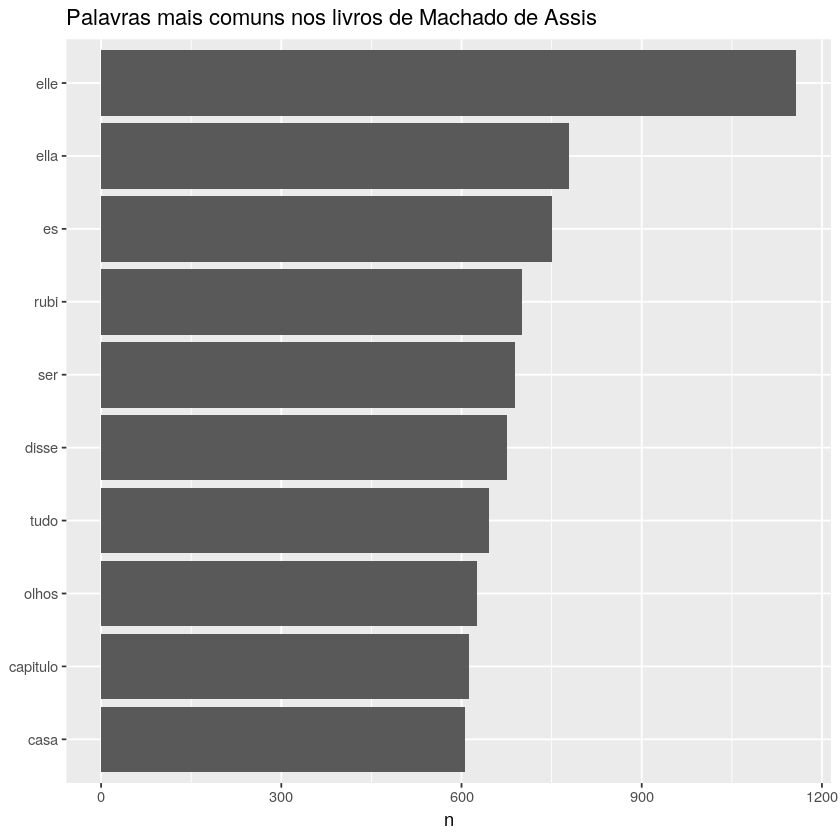

In [22]:
tidy_machado %>%
  count(word, sort = TRUE) %>%
  filter(n > 600) %>%
  mutate(word = reorder(word, n)) %>%
  ggplot(aes(word, n)) +
  geom_col() +
  xlab(NULL) +
  coord_flip() + ggtitle("Palavras mais comuns nos livros de Machado de Assis")

In [23]:
bing_word_counts <- tidy_machado %>%
  inner_join(get_sentiments("bing")) %>%
  count(word, sentiment, sort = TRUE) %>%
  ungroup()
bing_word_counts

Joining, by = "word"


word,sentiment,n
mar,negative,90
favor,positive,42
impress,positive,39
valor,positive,27
rumor,negative,24
terror,negative,22
sublime,positive,21
solid,positive,20
superior,positive,19
vulgar,negative,19


Selecting by n


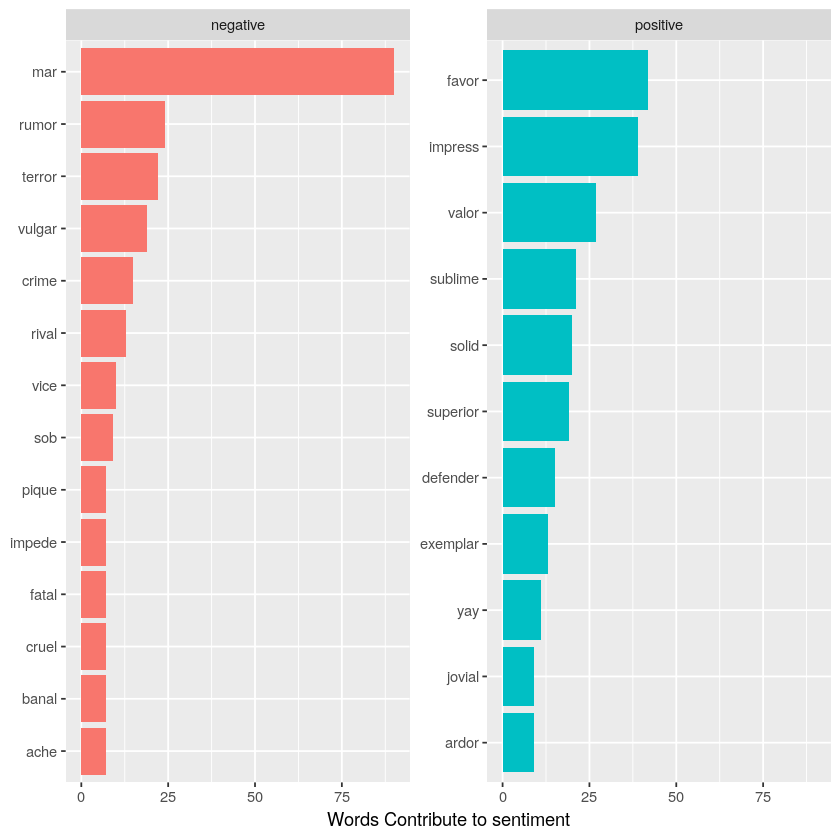

In [24]:
bing_word_counts %>%
  group_by(sentiment) %>%
  top_n(10) %>%
  ungroup() %>%
  mutate(word = reorder(word, n)) %>%
  ggplot(aes(word, n, fill = sentiment)) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~sentiment, scales = "free_y") +
  labs(y = "Words Contribute to sentiment",
       x = NULL) +
  coord_flip()

Joining, by = "word"


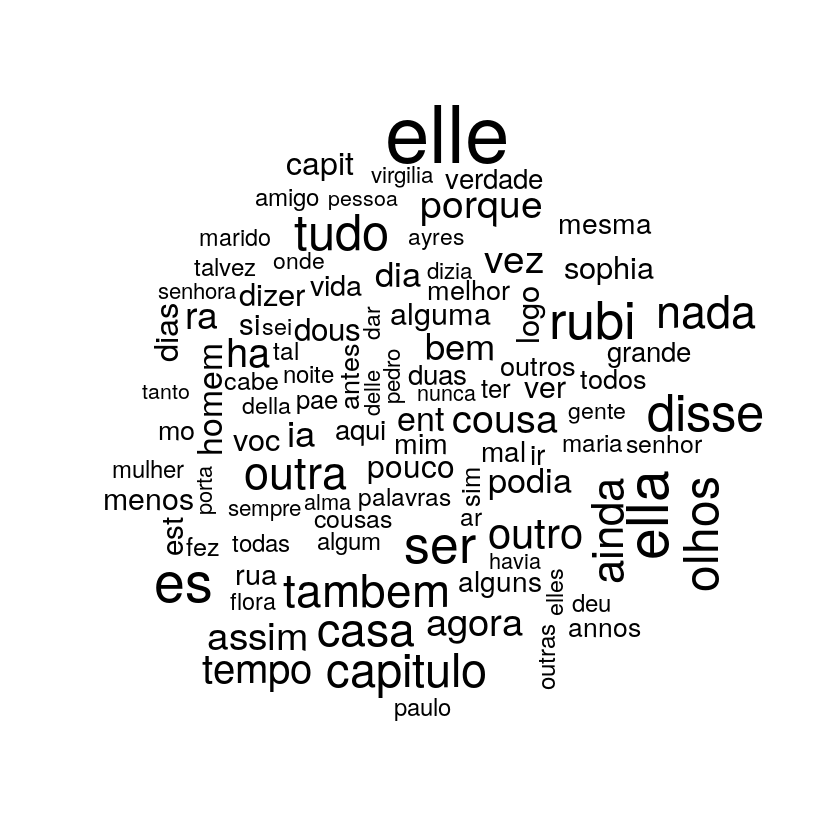

In [30]:
tidy_machado %>%
  anti_join(stop_words) %>%
  count(word) %>%
  with(wordcloud(word, n, max.words = 100))

Joining, by = "word"


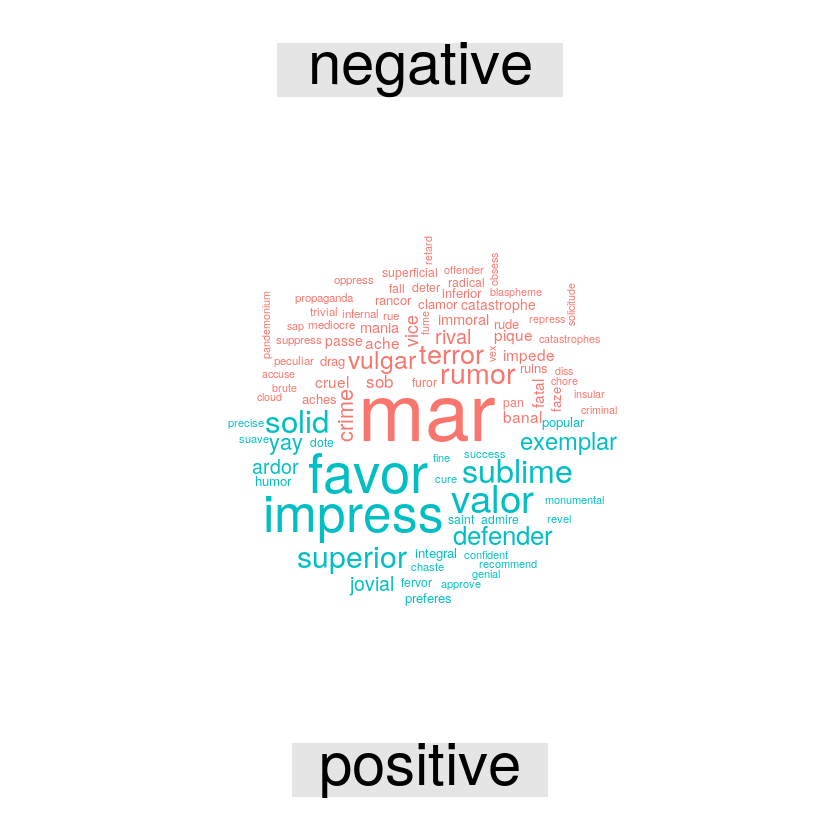

In [31]:
# library(reshape2)
tidy_machado %>%
  inner_join(get_sentiments("bing")) %>%
  count(word, sentiment, sort = TRUE) %>%
  acast(word ~ sentiment, value.var = "n", fill = 0) %>%
  comparison.cloud(colors = c("#F8766D", "#00BFC4"),
                   max.words = 100)

In [32]:
machado_bigrams <- machado %>%
  unnest_tokens(bigram, text, token = "ngrams", n = 2)
machado_bigrams

gutenberg_id,bigram
54829,mem rias
54829,rias p
54829,p sthumas
54829,sthumas de
54829,de braz
54829,braz cubas
54829,cubas por
54829,por machado
54829,machado de
54829,de assis


In [33]:
# library(tidyr)
bigrams_separated <- machado_bigrams %>%
  separate(bigram, c("word1", "word2"), sep = " ")
bigrams_filtered <- bigrams_separated %>%
  filter(!word1 %in% stop_words$word) %>%
  filter(!word2 %in% stop_words$word)
bigram_counts <- bigrams_filtered %>% 
  count(word1, word2, sort = TRUE)
bigram_counts

word1,word2,n
de,um,428
os,olhos,425
de,uma,317
de,ser,193
era,um,189
quincas,borba,160
jos,dias,151
como,se,148
alguma,cousa,146
um,dia,143


In [34]:
bigrams_united <- bigrams_filtered %>%
  unite(bigram, word1, word2, sep = " ")
bigrams_united

gutenberg_id,bigram
54829,mem rias
54829,sthumas de
54829,de braz
54829,braz cubas
54829,cubas por
54829,por machado
54829,machado de
54829,de assis
54829,assis rio
54829,rio de


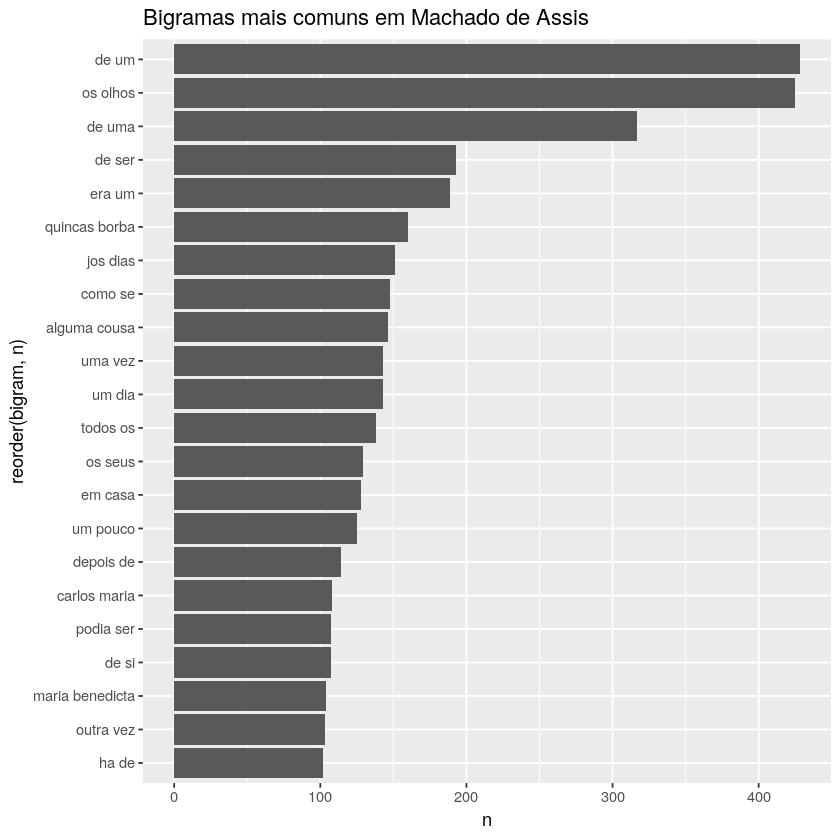

In [36]:
bigram_tf_idf <- bigrams_united %>%
  count(bigram)
bigram_tf_idf <- bigram_tf_idf %>% filter(n>100)
ggplot(aes(x = reorder(bigram, n), y=n), data=bigram_tf_idf) + geom_bar(stat = 'identity') + ggtitle("Bigramas mais comuns em Machado de Assis") + coord_flip()

In [45]:
bigram_graph <- bigram_counts %>%
  filter(n > 40) %>%
  graph_from_data_frame()
bigram_graph

IGRAPH 59e1259 DN-- 106 123 -- 
+ attr: name (v/c), n (e/n)
+ edges from 59e1259 (vertex names):
 [1] de     ->um        os     ->olhos     de     ->uma       de     ->ser      
 [5] era    ->um        quincas->borba     jos    ->dias      como   ->se       
 [9] alguma ->cousa     um     ->dia       uma    ->vez       todos  ->os       
[13] os     ->seus      em     ->casa      um     ->pouco     depois ->de       
[17] carlos ->maria     de     ->si        podia  ->ser       maria  ->benedicta
[21] outra  ->vez       ha     ->de        outra  ->cousa     na     ->rua      
[25] era    ->uma       da     ->minha     um     ->homem     da     ->casa     
[29] de     ->mim       se     ->lhe       os     ->dous      da     ->vida     
+ ... omitted several edges

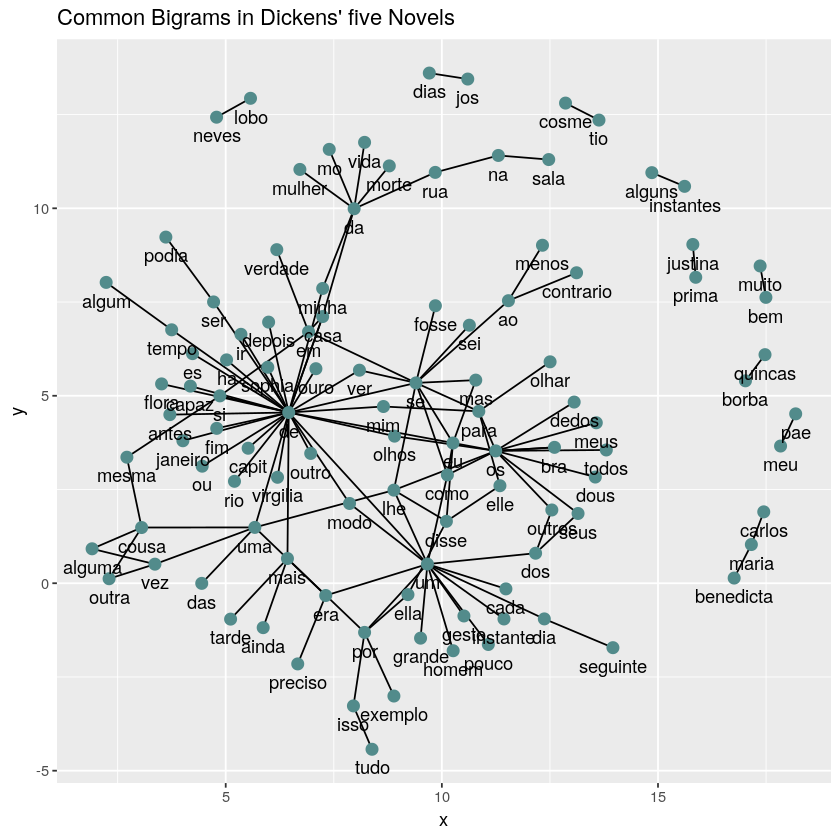

In [46]:
set.seed(2019)
ggraph(bigram_graph, layout = "fr") +
  geom_edge_link() +
  geom_node_point(color = "darkslategray4", size = 3) +
  geom_node_text(aes(label = name), vjust = 1.8) + ggtitle("Common Bigrams in Dickens' five Novels")